_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: <span style='background: black'>Artemii Shlychkov, Elias Seiffert, Arne Gittel  </span>

# Coding Lab 1

- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
import sklearn as sk
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-04-29 21:49:35CEST

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

sklearn: 1.4.1.post1

scipy     : 1.12.0
sklearn   : 1.4.1.post1
pandas    : 2.2.1
numpy     : 1.26.4
matplotlib: 3.8.3

Watermark: 2.4.3



In [2]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [4]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 2 pts*


In [5]:
# get the data from the pandas dataframe
Ch1 = x["Ch1"].values
Ch2 = x["Ch2"].values
Ch3 = x["Ch3"].values
Ch4 = x["Ch4"].values

Raw_data = np.array([Ch1, Ch2, Ch3, Ch4]) # create a numpy array from the raw data
timeline = np.arange(
    0, len(Ch1) / fs, 1 / fs
)  # timeline in seconds for plotting the signal later

In [6]:
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 4
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """

    # insert your code here

    # --------------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1.5 pts)
    # --------------------------------------------------------------------
    x = np.array(x)
    b, a = signal.butter(
        order, [low, high], btype="bandpass", fs=fs
    )  # bandpass butter filter
    y = signal.filtfilt(
        b, a, x
    )  # apply filter to the data. Note that the filtfilt is a zero-phase shift filter
    return y

At first we tested the sosfilt and the lfilter. However they yielded poorer results, reflected in more noisy spike waveforms and poorer PCA outcome. Possibly, because unlike filtfilt, these two do not have a zero phase-shift. Using different order of filters does not seem to influence results as much.

### Testing the filter

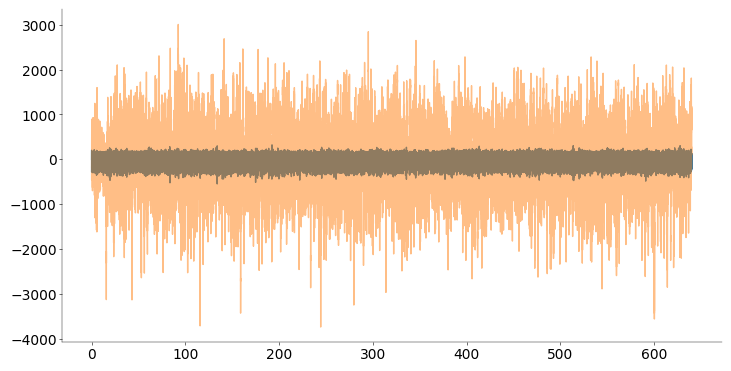

In [7]:
Filtered_data = filter_signal(Raw_data, fs, 500, 4000)  # apply filter to the data

# plot the filtered data and the raw data for comparison
# print(Filtered_data.shape)
plt.plot(timeline, Filtered_data[1])
plt.plot(timeline, Raw_data[1], alpha=0.5)

From this plot we can also get a raw representation of the boundaries of our signals

### Plotting all 4 channels for comparison

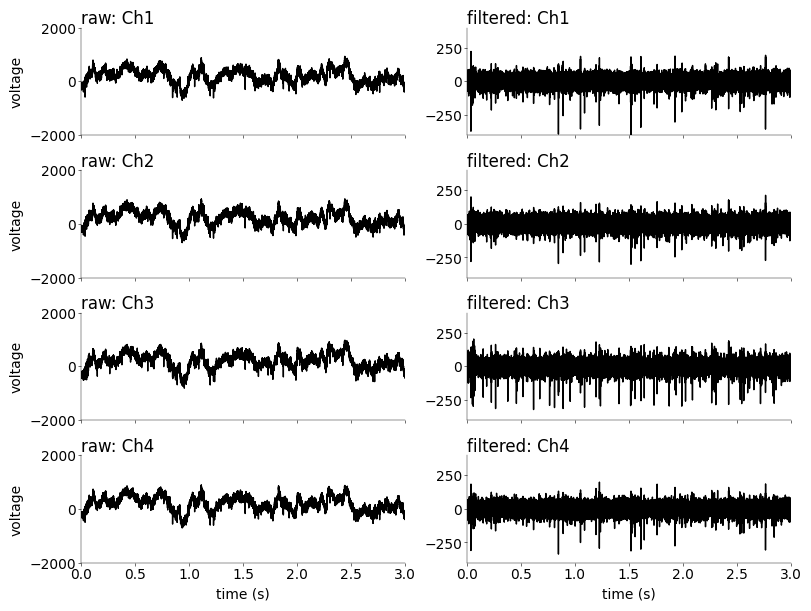

In [8]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]  # mosaic layout for the subplots
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)  # create the figure and axes

# -----------------------------------------------------------------
# Plot raw and filtered signal segments for all 4 channels (0.5 pt)
# -----------------------------------------------------------------
for i, m in enumerate(mosaic):  # iterate over the subplots
    raw = m[0]
    filtered = m[1]
    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-2000, 2000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 400))

    ax[raw].set_ylabel("voltage")
    ax[filtered].set_title(m[1], loc="left")

    ax[raw].set_title(m[0], loc="left")

    ax[raw].plot(timeline, Raw_data[i], color="black")  # plot the raw data
    # print(np.max(Raw_data[i]))
    ax[filtered].plot(
        timeline, Filtered_data[i], color="black"
    )  # plot the filtered data

    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

In [53]:
def detect_spikes(
    x: np.ndarray, timeline, fs: float, N: int = 5, lockout: int = 10
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes, in this case, the relative local minima of the signal x.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: int
        a window of 'refactory period', within which there's only one spike.
        Default is 10 but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes,)
        Spike location / index in the singal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    a: np.array, (n_spikes,  )
        Amplitude of the spike.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    Use scipy functions to detect local minima.
    Noted that there are four channels in signal x.

    """
    # insert your code here

    # -----------------------------------------------------------------------
    # compute the robust s.d. (0.5 pts) and calculate the threshold (0.5 pts)
    # -----------------------------------------------------------------------
    s_d_list = []
    thrd_list = []
    spike_list = []

    s = np.empty((0, 2), int)
    a = np.empty((0, 2), int)

    for i in range(Filtered_data.shape[0]):

        s_d_list.append(np.median(np.abs(x[i] - np.mean(x[i]))) / 0.6745)
        thrd_list.append(-N * s_d_list[i])
        # print(s_d_list[i], thrd_list[i])
        # -------------------------------
        # find all local minima (1.5 pts)
        # -------------------------------
        spike_idx = signal.find_peaks(-x[i], height=-thrd_list[i], distance=lockout)

        spike_list.append(spike_idx[0])

        ch = np.full_like(spike_idx[0], i)

        stacked = np.column_stack((spike_idx[0], ch))

        s = np.vstack((s, np.column_stack((spike_idx[0], ch))))

        stacked = np.column_stack((x[i][spike_idx[0]], ch))
        a = np.vstack((a, np.column_stack((x[i][spike_idx[0]], ch))))
    t = s.copy().astype(float)

    t[:, 0] = t[:, 0] / fs

    return (
        spike_list,
        thrd_list,
        s,
        t,
        a,
    )

Choosing N = 5 seemed to make the signal a bit less noisy, compared to N = 4, so we decided to stick with it

In [54]:
(
    spike_list,
    thrd_list,
    s,
    t,
    a,
) = detect_spikes(Filtered_data, timeline, fs)

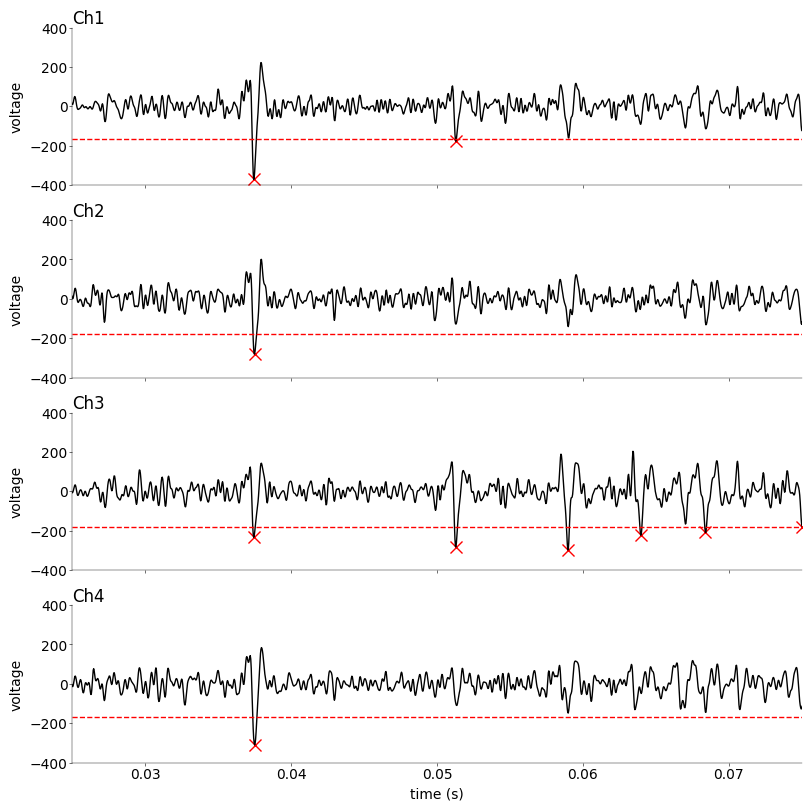

In [55]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# --------------------------------------------
# plot threshold and detected spikes (0.5 pts)
# --------------------------------------------

for i, col in enumerate(cols):
    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage")

    ax[col].set_title(col, loc="left")

    ax[col].plot(timeline, Filtered_data[i], color="black")

    ax[col].axhline(thrd_list[i], color="red", linestyle="--")

    ax[col].scatter(
        t[t[:, 1] == i][:, 0],
        a[a[:, 1] == i][:, 0],
        color="red",
        s=75,
        marker="x",
    )

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")
# ax["Ch3"].vlines(p, -400, 400, color="blue", linestyle="--")

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [56]:
# concatenate the spike list in order to assemble the w matrix in the next cell
s_1 = np.concatenate(spike_list).astype(int)

In [57]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times othrdf the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """

    # insert your code here
    window = 15

    n_spikes = sum([len(i) for i in spike_list])

    w = np.zeros((n_spikes, 2 * window, 4))
    # print("s", s.shape)
    # print(s[0])
    # print("s", np.shape(s))
    # s[2] = s[2][1:]
    for channel in range(4):
        # print(len(s))
        # print(n_spikes)
        for i in range(n_spikes):
            w[i, :, channel] = x[channel][s[i] - 15 : s[i] + 15]

    # ------------------------------
    # extract spike waveforms (1 pt)
    # ------------------------------
    return w

In [58]:
# extract the waveforms from the filtered data
w = extract_waveforms(Filtered_data, s_1)

Plot first 100 spike waveforms

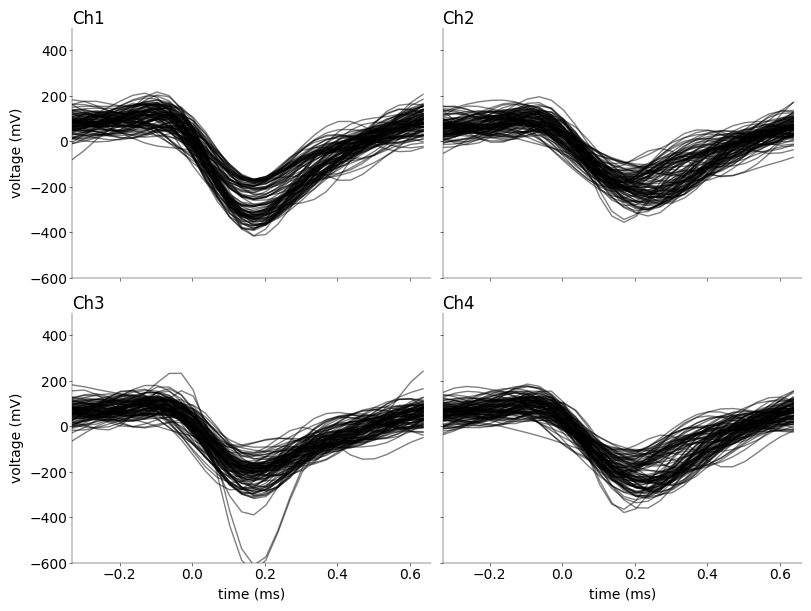

In [59]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------
# plot first 100 spikes (0.5 pts)
# -------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    ax[col].set_ylim((-600, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    for k in range(100):
        ax[col].plot(
            np.arange(0, len(w[k, :, i]) / fs, 1 / fs) * 1000 - 0.33,
            w[k, :, i],
            color="black",
            alpha=0.5,
        )

    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (mV)")
    else:
        ax[col].set_yticklabels([])

There are idividual tracks that do not follow the same pattern as others (have other shape), which look more like noise. However most of the detected spikes share pretty much the same shape. The amplitude of the spikes is mostly homogenous within channels, with the spikes ranging approximately from -400 to 200 mV. Only Channel_3 has 2 outliers with negative amplitude beyond -600 mV.

Plot largest 100 spike waveforms

In [60]:
# sort the spikes by their amplitude

spike_height_list = []
for i in range(4):
    spikes_ch = w[:, :, i]
    largest_spikes = spikes_ch[
        np.argsort(-np.max(spikes_ch, axis=1))
    ]  # sort the spikes by the max value in the window
    spike_height_list.append(largest_spikes)

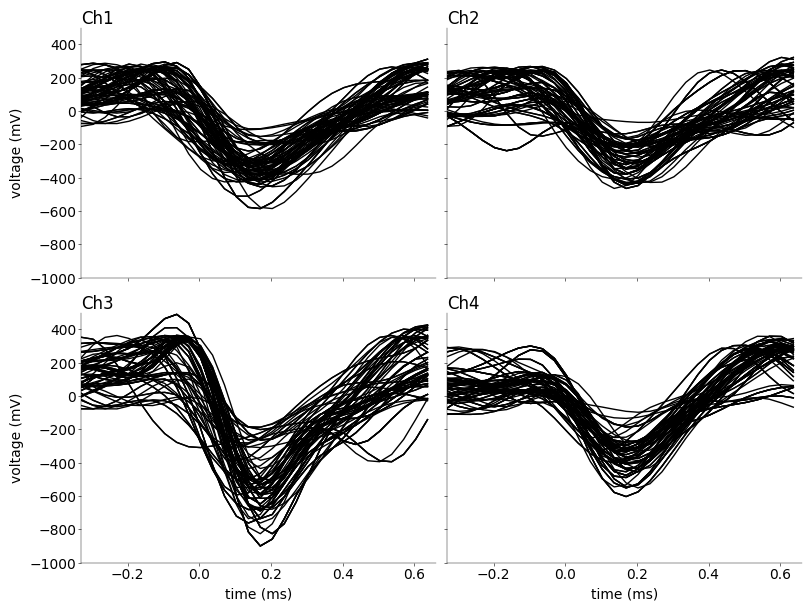

In [61]:
mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# -------------------------------------
# plot the largest 100 spikes (0.5 pts)
# -------------------------------------


# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    for j in range(100):

        ax[col].plot(
            np.arange(0, len(w[k, :, i]) / fs, 1 / fs) * 1000 - 0.33,
            spike_height_list[i][j],
            color="black",
        )

    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (mV)")
    else:
        ax[col].set_yticklabels([])

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()``` (2 pts). You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


### PCA:
- how to preprocess data?


(https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca)

In [62]:
def extract_features(w: np.ndarray):
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    n_spikes, length_window, n_channels = w.shape
    b = np.empty((n_spikes, 0))
    pca = PCA(n_components=3, whiten=False, svd_solver="full")

    for i in range(n_channels):
        data = w[:, :, i]
        data = sk.preprocessing.scale(
            data, axis=0
        )  # Scale data to zero mean and unit variance
        # data = sk.preprocessing.normalize(data, axis=0)  # Normalize data
        pca.fit(data)
        print(f"Channel {i+1} explained variance ratio:", pca.explained_variance_ratio_)
        transform = pca.transform(data)
        b = np.concatenate((b, transform), axis=1)

    return b

    # insert your code here

    # ---------------------------------------------
    # obtain first 3 principle components (2 pts)
    # ---------------------------------------------

    # -----------------------------------------------------
    # Print the fraction of variance explained (1 pt)
    # -----------------------------------------------------

In [74]:
def manual_PCA(w):
    n_spikes, length_window, n_channels = w.shape
    b = np.empty((n_spikes, 0))
    # scale data to zero mean and unit variance
    mean = np.mean(w, axis=0)
    std = np.std(w, axis=0)
    w = (w - mean) / std
    for channel in range(4):
        data = w[:, :, channel]
        # calculate mean
        mean = np.mean(data, axis=1)
        # subtract mean from data
        data = data - mean[:, np.newaxis]
        # calculate covariance matrix
        cov = np.cov(data, rowvar=False)
        # calculate eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eig(cov)
        # sort eigenvectors by eigenvalues
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        # project data onto the first 3 principal components
        proj = np.dot(data, eigvecs[:, :3])
        b = np.concatenate((b, proj), axis=1)
        print(
            f"Channel {channel+1} explained variance ratio:",
            eigvals[:3] / np.sum(eigvals),
        )
    return b

In [77]:
features = extract_features(w)  # perform the sklearn PCA
# features = manual_PCA(w)  # perform the manual PCA

Channel 1 explained variance ratio: [0.39924136 0.275487   0.11556428]
Channel 2 explained variance ratio: [0.34882095 0.26915598 0.12857635]
Channel 3 explained variance ratio: [0.37474996 0.24647422 0.13888278]
Channel 4 explained variance ratio: [0.35403661 0.27009761 0.13241057]


Text(0.5, 0.98, 'Pairwise 1st PCs')

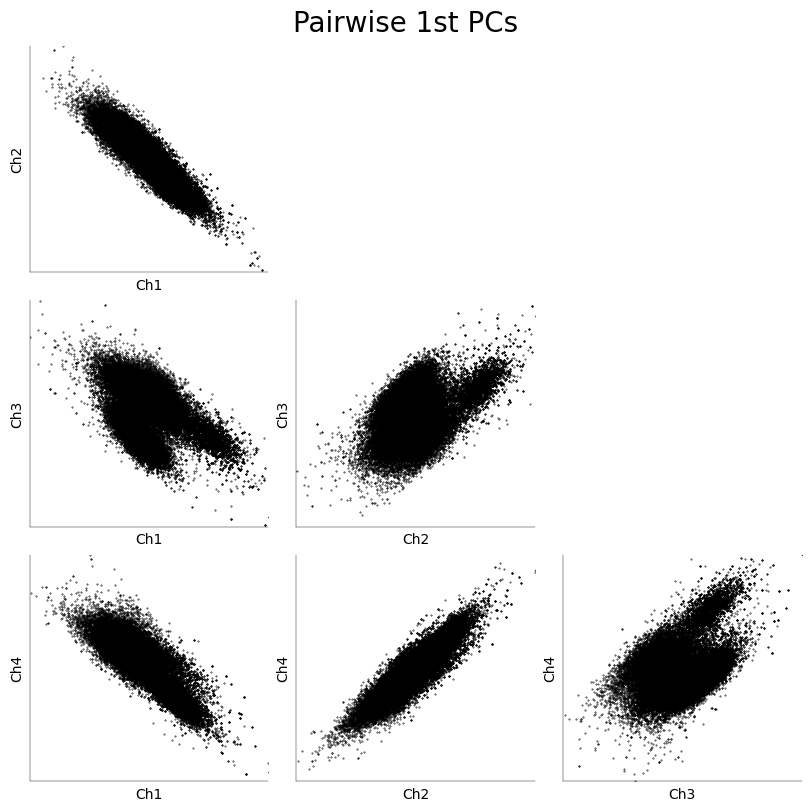

In [78]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    y, x = m.split(" vs ")

    a = i[y]
    b = i[x]
    ax[m].scatter(features[:, a], features[:, b], s=0.5, color="black")
    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)
    ax[m].set_xlim((-15, 15))
    ax[m].set_ylim((-15, 15))
    ax[m].set_xticks([])
    ax[m].set_yticks([])


fig.suptitle("Pairwise 1st PCs", fontsize=20)

The clusters (up to 3) can be visually distinguished in "Ch1 vs Ch3", "Ch2 vs Ch3", and in "Ch3 vs Ch4" plots. Clustering indicates that spikes probably come from different neurons. Manual PCA and sk_learn PCA produce similar results given proper scaling and normalization

In [79]:
# # save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)